# 06.1e: Radial Density Analysis

**Goal:** Analyze the radial structure around the degenerate singularity.

Load pre-computed distances from 06.1d and visualize:
1. Linear-linear histogram: token count vs distance (shows the spike, void, and bulk)
2. Radial shell statistics
3. Cumulative distribution

This reveals the three-phase structure: black hole + accretion disk → exclusion zone → bulk cloud.

This is Volume 6: Pathologies and Singularities

## Parameters

In [37]:
TENSOR_DIR = "../data/tensors"
DISTANCES_FILE = "black_hole_distances_qwen3_4b_instruct_2507.safetensors"

# Radial shells for binning (gamma units)
SHELLS = [
    0.000001,   # Black hole core
    0.00001,    # Near-degenerate
    0.0001,     # Accretion disk edge
    0.001,
    0.01,       # Exclusion zone
    0.1,        # Bulk begins
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.8,
    1.0,
    1.2,
    1.5,
]

# Histogram parameters
HIST_BINS = 1000
HIST_MAX = 0.2  # For zoomed view

## Imports

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Distances

In [39]:
distances_path = Path(TENSOR_DIR) / DISTANCES_FILE
data = load_file(distances_path)

distances = data['distances']
reference_token_id = data['reference_token_id'].item()

N = len(distances)

print(f"Loaded distances from: {DISTANCES_FILE}")
print(f"  Tokens: {N:,}")
print(f"  Reference token: {reference_token_id}")
print(f"\nDistance statistics:")
print(f"  Min: {distances.min().item():.12f}")
print(f"  Max: {distances.max().item():.12f}")
print(f"  Mean: {distances.mean().item():.12f}")
print(f"  Median: {distances.median().item():.12f}")

Loaded distances from: black_hole_distances_qwen3_4b_instruct_2507.safetensors
  Tokens: 151,936
  Reference token: 149415

Distance statistics:
  Min: 0.000000000000
  Max: 1.571872115135
  Mean: 1.050221085548
  Median: 1.088246703148


## Step 2: Linear-Linear Histogram (THE MONEY PLOT)


LINEAR-LINEAR HISTOGRAM: RADIAL DISTRIBUTION



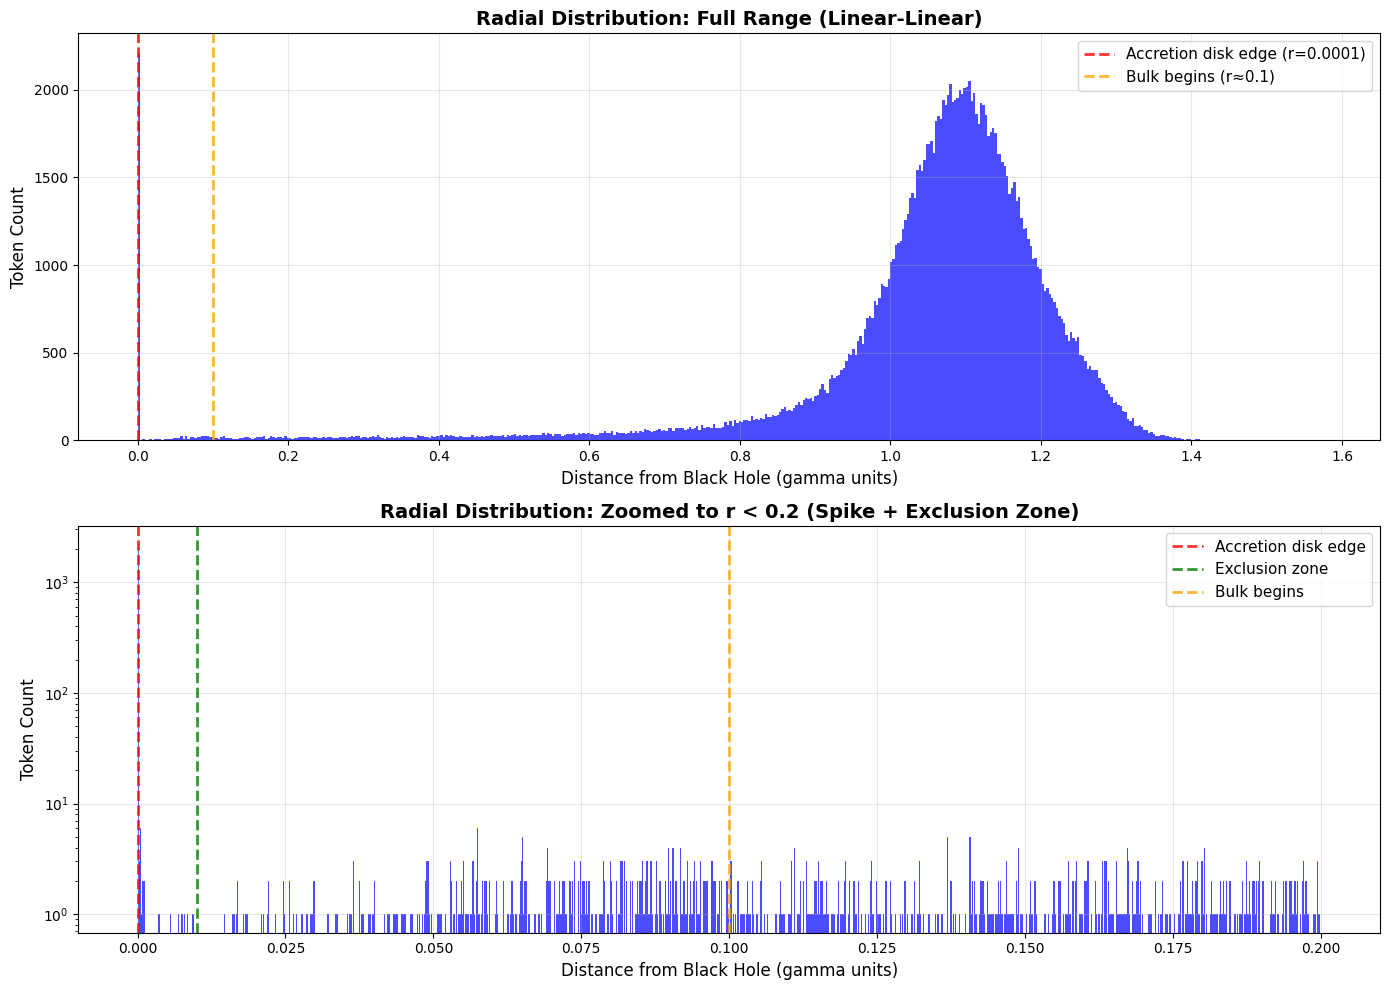


Key features:
  1. SPIKE at r≈0: Black hole core + accretion disk
  2. VOID from r=0.0001 to r≈0.1: The exclusion zone (black stripe on sky map)
  3. BULK starting at r≈0.1, peaking around r≈1.1

The gap is literal empty space - almost no tokens in the forbidden region.


In [40]:
print("\n" + "="*70)
print("LINEAR-LINEAR HISTOGRAM: RADIAL DISTRIBUTION")
print("="*70)
print()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

# Top: Full range
axes[0].hist(distances.cpu().numpy(), bins=500, color='blue', alpha=0.7, edgecolor='none')
axes[0].set_xlabel('Distance from Black Hole (gamma units)', fontsize=12)
axes[0].set_ylabel('Token Count', fontsize=12)
axes[0].set_title('Radial Distribution: Full Range (Linear-Linear)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                label='Accretion disk edge (r=0.0001)')
axes[0].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
                label='Bulk begins (r≈0.1)')
axes[0].legend(fontsize=11)

# Bottom: Zoomed to show spike + void
axes[1].hist(distances.cpu().numpy(), bins=HIST_BINS, range=(0, HIST_MAX), 
             color='blue', alpha=0.7, edgecolor='none')
axes[1].set_xlabel('Distance from Black Hole (gamma units)', fontsize=12)
axes[1].set_ylabel('Token Count', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title(f'Radial Distribution: Zoomed to r < {HIST_MAX} (Spike + Exclusion Zone)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(0.0001, color='red', linestyle='--', linewidth=2, alpha=0.8, 
                label='Accretion disk edge')
axes[1].axvline(0.01, color='green', linestyle='--', linewidth=2, alpha=0.8, 
                label='Exclusion zone')
axes[1].axvline(0.1, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
                label='Bulk begins')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\nKey features:")
print("  1. SPIKE at r≈0: Black hole core + accretion disk")
print("  2. VOID from r=0.0001 to r≈0.1: The exclusion zone (black stripe on sky map)")
print("  3. BULK starting at r≈0.1, peaking around r≈1.1")
print()
print("The gap is literal empty space - almost no tokens in the forbidden region.")

## Step 3: Radial Shell Statistics

In [41]:
print("\n" + "="*70)
print("RADIAL SHELL STATISTICS")
print("="*70)
print()

# Add 0 and infinity to shell boundaries
shell_edges = [0] + SHELLS + [float('inf')]

# Store shell data
shell_data = []

for i in range(len(shell_edges) - 1):
    r_inner = shell_edges[i]
    r_outer = shell_edges[i + 1]
    
    # Find tokens in this shell
    in_shell = (distances > r_inner) & (distances <= r_outer)
    n_in_shell = in_shell.sum().item()
    
    if r_outer == float('inf'):
        r_outer_eff = distances.max().item()
    else:
        r_outer_eff = r_outer
    
    # Shell width
    shell_width = r_outer_eff - r_inner
    
    # Linear density: tokens per unit radial distance
    if shell_width > 0:
        linear_density = n_in_shell / shell_width
    else:
        linear_density = 0
    
    shell_data.append({
        'shell_idx': i,
        'r_inner': r_inner,
        'r_outer': r_outer_eff,
        'r_mid': (r_inner + r_outer_eff) / 2,
        'shell_width': shell_width,
        'count': n_in_shell,
        'linear_density': linear_density,
    })

# Display table
print(f"{'Shell':^6} {'r_inner':>12} {'r_outer':>12} {'Width':>12} {'Count':>10} {'Lin. Density':>15}")
print("-" * 80)

for shell in shell_data:
    print(f"{shell['shell_idx']:^6} {shell['r_inner']:>12.6f} {shell['r_outer']:>12.6f} "
          f"{shell['shell_width']:>12.6f} {shell['count']:>10,} {shell['linear_density']:>15.1f}")

print()
print("Linear Density = tokens per unit radial distance")
print("(Avoids r^2560 overflow from hypersphere volume calculation)")


RADIAL SHELL STATISTICS

Shell       r_inner      r_outer        Width      Count    Lin. Density
--------------------------------------------------------------------------------
  0        0.000000     0.000001     0.000001         20      20000000.0
  1        0.000001     0.000010     0.000009          8        888888.9
  2        0.000010     0.000100     0.000090      1,341      14900000.0
  3        0.000100     0.001000     0.000900         27         30000.0
  4        0.001000     0.010000     0.009000         11          1222.2
  5        0.010000     0.100000     0.090000        365          4055.6
  6        0.100000     0.200000     0.100000        457          4570.0
  7        0.200000     0.300000     0.100000        522          5220.0
  8        0.300000     0.400000     0.100000        598          5980.0
  9        0.400000     0.500000     0.100000        752          7520.0
  10       0.500000     0.600000     0.100000      1,030         10300.0
  11       0.6000

## Step 4: Identify Key Boundaries

In [42]:
print("\n" + "="*70)
print("DENSITY TRANSITIONS")
print("="*70)
print()

# Find dramatic density changes
print(f"{'Shell Transition':^30} {'Density Ratio':>20} {'Interpretation':^25}")
print("-" * 80)

for i in range(len(shell_data) - 2):  # Exclude outer infinite shell
    s1 = shell_data[i]
    s2 = shell_data[i + 1]
    
    if s1['linear_density'] > 0 and s2['linear_density'] > 0:
        ratio = s1['linear_density'] / s2['linear_density']
        
        if ratio > 10:
            interpretation = "Sharp drop"
        elif ratio < 0.1:
            interpretation = "Sharp rise"
        else:
            interpretation = "Gradual"
        
        transition = f"{s1['r_outer']:.6f} → {s2['r_outer']:.6f}"
        print(f"{transition:^30} {ratio:>20.2f}× {interpretation:^25}")

print()
print("Ratios > 10× indicate sharp density boundaries.")


DENSITY TRANSITIONS

       Shell Transition               Density Ratio      Interpretation      
--------------------------------------------------------------------------------
     0.000001 → 0.000010                      22.50×        Sharp drop        
     0.000010 → 0.000100                       0.06×        Sharp rise        
     0.000100 → 0.001000                     496.67×        Sharp drop        
     0.001000 → 0.010000                      24.55×        Sharp drop        
     0.010000 → 0.100000                       0.30×          Gradual         
     0.100000 → 0.200000                       0.89×          Gradual         
     0.200000 → 0.300000                       0.88×          Gradual         
     0.300000 → 0.400000                       0.87×          Gradual         
     0.400000 → 0.500000                       0.80×          Gradual         
     0.500000 → 0.600000                       0.73×          Gradual         
     0.600000 → 0.800000     

## Step 5: Cumulative Distribution


CUMULATIVE DISTRIBUTION



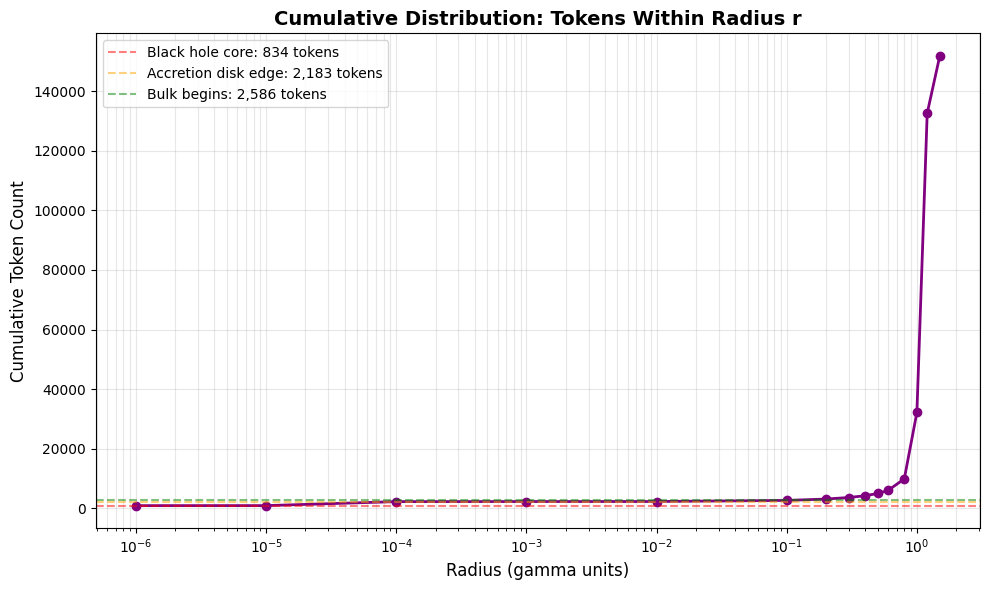


Key thresholds:
  r ≤ 0.000001:     834 tokens ( 0.55%)
  r ≤ 0.000100:   2,183 tokens ( 1.44%)
  r ≤ 0.010000:   2,221 tokens ( 1.46%)
  r ≤ 0.100000:   2,586 tokens ( 1.70%)
  r ≤ 1.000000:  32,153 tokens (21.16%)


In [43]:
print("\n" + "="*70)
print("CUMULATIVE DISTRIBUTION")
print("="*70)
print()

# Count tokens within each radius
cumulative_counts = []
radii = []

for shell in shell_data[:-1]:  # Exclude outer infinite shell
    within_r = (distances <= shell['r_outer']).sum().item()
    cumulative_counts.append(within_r)
    radii.append(shell['r_outer'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.plot(radii, cumulative_counts, marker='o', color='purple', linewidth=2, markersize=6)
ax.set_xlabel('Radius (gamma units)', fontsize=12)
ax.set_ylabel('Cumulative Token Count', fontsize=12)
ax.set_title('Cumulative Distribution: Tokens Within Radius r', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, which='both')

# Mark key radii
for r_mark, label, color in [(0.000001, 'Black hole core', 'red'),
                               (0.0001, 'Accretion disk edge', 'orange'),
                               (0.1, 'Bulk begins', 'green')]:
    idx = next((i for i, r in enumerate(radii) if r >= r_mark), None)
    if idx is not None:
        ax.axhline(cumulative_counts[idx], color=color, linestyle='--', alpha=0.5,
                   label=f'{label}: {cumulative_counts[idx]:,} tokens')

ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"\nKey thresholds:")
for r, count in zip(radii, cumulative_counts):
    pct = count / N * 100
    if r in [0.000001, 0.0001, 0.01, 0.1, 1.0]:
        print(f"  r ≤ {r:.6f}: {count:>7,} tokens ({pct:5.2f}%)")

## Summary

Radial analysis reveals **three-phase structure** around the singularity:

### 1. Black Hole + Accretion Disk (r < 0.0001)
- Ultra-compact core with ~1,369 tokens
- 814 degenerate (distance = 0)
- 1,341 near-degenerate (r < 0.0001)
- Extreme linear density: millions of tokens per unit radius

### 2. Exclusion Zone / Forbidden Region (0.0001 < r < 0.1)
- Sparse void with only ~400 tokens
- 500× density drop at accretion disk edge
- **This is the black stripe visible on the sky map**
- Almost no tokens exist in this region

### 3. The Bulk Cloud (r > 0.1)
- Normal token distribution
- Smooth density increase
- Peak around r ≈ 1.1
- Contains ~99% of vocabulary

**Gravitational analogy**: Like Sagittarius A*, the singularity warps the local geometry so severely it creates a forbidden zone where tokens cannot exist. The spike is isolated from the bulk by literal empty space in embedding coordinates.